In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tensorflow as tf
import tensorflow_probability as tfp
import h5py
import random
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

import sys,os
import numpy as np
import pandas as pd
import random
import h5py

2023-07-27 03:45:14.012253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 03:45:14.553147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tfpl = tfp.layers
tf1 = tf.compat.v1
tfd = tfp.distributions

In [3]:
from tensorflow_probability.python.distributions import kl_divergence

In [4]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-07-27 03:45:15.566017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-27 03:45:15.584138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-27 03:45:15.584338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
n = 10000
t = 2000
v = 2000

In [6]:
hf_train = h5py.File('/data/HSC/HSC_v6/step3/64x64_training_small.hdf5', 'r')
# hf_test = h5py.File('/data3/Diffusion/127x127_diffusion_regenerated_light.hdf5', 'r')
# hf_test = h5py.File('/data/HSC/HSC_v6/step3/127x127_generated_train.hdf5', 'r')\
hf_test = h5py.File('/data3/Diffusion/64x64_diffusion_generated_normalized.hdf5', 'r')
# hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step3/64x64_validation_small.hdf5', 'r')
x_train = np.asarray(np.transpose(hf_train['image'][0:],(0,2,3,1)))
x_test = np.asarray(np.transpose(hf_test['image'][0:],(0,2,3,1)))
x_validation = np.asarray(np.transpose(hf_validation['image'][0:],(0,2,3,1)))
t = len(x_test)
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, 1)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:])[..., None]
hf_train.close()
hf_test.close()
hf_validation.close()

In [7]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype = dtype, initializer = lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable = True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc = t[ ..., : n],
                       scale = tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims = 1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype = dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc = t, scale = 0.01),
            reinterpreted_batch_ndims = 1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean = 0., stddev = 0.03)
    loc = tf.Variable(
        initial_value = loc_norm(shape = (n, ), dtype = dtype)
    )
    scale_norm = tf.random_normal_initializer(mean = -3., stddev = 0.1)
    scale = tf.Variable(
        initial_value = scale_norm(shape = (n, ), dtype = dtype)
    )
    return tf.concat([loc, scale], 0)

kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

In [8]:
import keras
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [9]:
model_variational = Sequential([
    InputLayer(input_shape = (64, 64, 5)),
    tfpl.Convolution2DFlipout(32, kernel_size=(3, 3), activation = 'tanh', kernel_divergence_fn = kl_divergence_function),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (2, 2), activation = 'tanh'),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
    Conv2D(32, kernel_size = (2, 2), activation = 'relu'),
    Flatten(),
    Dropout(0.2),
    tfpl.DenseVariational(128, 
                                      make_posterior_fn = posterior_mean_field,
                                      make_prior_fn = prior_trainable,
                                      kl_weight = 1 / n),
    tfpl.DenseVariational(128, 
                                      make_posterior_fn = posterior_mean_field,
                                      make_prior_fn = prior_trainable,
                                      kl_weight = 1 / n),
    Dense(tfpl.IndependentNormal.params_size(1)),
    tfpl.IndependentNormal(1)
])

model_variational.build((10000, 127, 127, 5))

model_variational.summary()

/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_flipout (Conv2DFlipo  (None, 62, 62, 32)       2912      
 ut)                                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                        

In [10]:
def loss_function(targets, estimated_distribution):
    return - estimated_distribution.log_prob(targets)

model_variational.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = loss_function, metrics = [keras.metrics.RootMeanSquaredError()])

In [11]:
import tensorboard

model_name = 'HSC_v6_BCNN_v5'

checkpoint_filepath = os.path.join('/models/', model_name) + '/' + model_name

weights_path = os.path.join('/models/', model_name) + '/weights'

log_dir = os.path.join('/logs/', model_name)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = True, verbose = 1, save_freq = 150*250)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

LR_callback = ReduceLROnPlateau()

In [12]:
model_variational.fit(x = x_train, y = y_train, epochs = 60, shuffle = True, verbose = 1, validation_data = (x_validation, y_validation), callbacks = [LR_callback])

Epoch 1/60


2023-07-27 03:45:36.799289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-27 03:45:37.493907: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-27 03:45:37.569665: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f494867df70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-27 03:45:37.569688: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-07-27 03:45:37.572992: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-27 03:45:37.627897: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-27 03:45:37.674517: I ./tensorflow/compiler/jit/device_compiler.h:

313/313 [==============================] - 8s 11ms/step - loss: 1656.2441 - root_mean_squared_error: 0.9304 - val_loss: 1376.3864 - val_root_mean_squared_error: 0.6984 - lr: 0.0010
Epoch 2/60
313/313 [==============================] - 3s 8ms/step - loss: 1184.5217 - root_mean_squared_error: 0.7165 - val_loss: 1015.8373 - val_root_mean_squared_error: 0.5913 - lr: 0.0010
Epoch 3/60
313/313 [==============================] - 3s 8ms/step - loss: 886.4349 - root_mean_squared_error: 0.7246 - val_loss: 770.3458 - val_root_mean_squared_error: 0.5371 - lr: 0.0010
Epoch 4/60
313/313 [==============================] - 3s 8ms/step - loss: 679.8166 - root_mean_squared_error: 0.6563 - val_loss: 597.2362 - val_root_mean_squared_error: 0.5862 - lr: 0.0010
Epoch 5/60
313/313 [==============================] - 3s 9ms/step - loss: 531.0334 - root_mean_squared_error: 0.7919 - val_loss: 469.8432 - val_root_mean_squared_error: 0.6516 - lr: 0.0010
Epoch 6/60
313/313 [==============================] - 3s 8ms/

# hf_test = h5py.File('/data3/Diffusion/127x127_diffusion_regenerated_light.hdf5', 'r')
hf_test = h5py.File('/data3/Diffusion/127x127_diffusion_generated_1.hdf5', 'r')
# hf_test = h5py.File('/data/HSC/HSC_v6/step3/127x127_generated_max_1.hdf5', 'r')
# hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing_small.hdf5', 'r')
x_test = np.asarray(np.transpose(hf_test['image'][0:],(0,2,3,1)))
t = len(x_test)
max_value = 1
x_test = np.true_divide(x_test, max_value)[0:t]
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None][0:t]
hf_test.close()

In [13]:
photoz = []

for i in range(t):
    photoz.append(model_variational(np.array([x_test[i]])).mean()[0][0])

photoz = np.asarray(photoz).astype('float32')

In [14]:
specz = np.asarray(y_test)[:,0]

In [15]:
photoz_err = []

for i in range(t):
    photoz_err.append(model_variational(np.array([x_test[i]])).stddev()[0][0])

In [16]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([specz, photoz])).astype('float32')
z = gaussian_kde(xy)(xy)

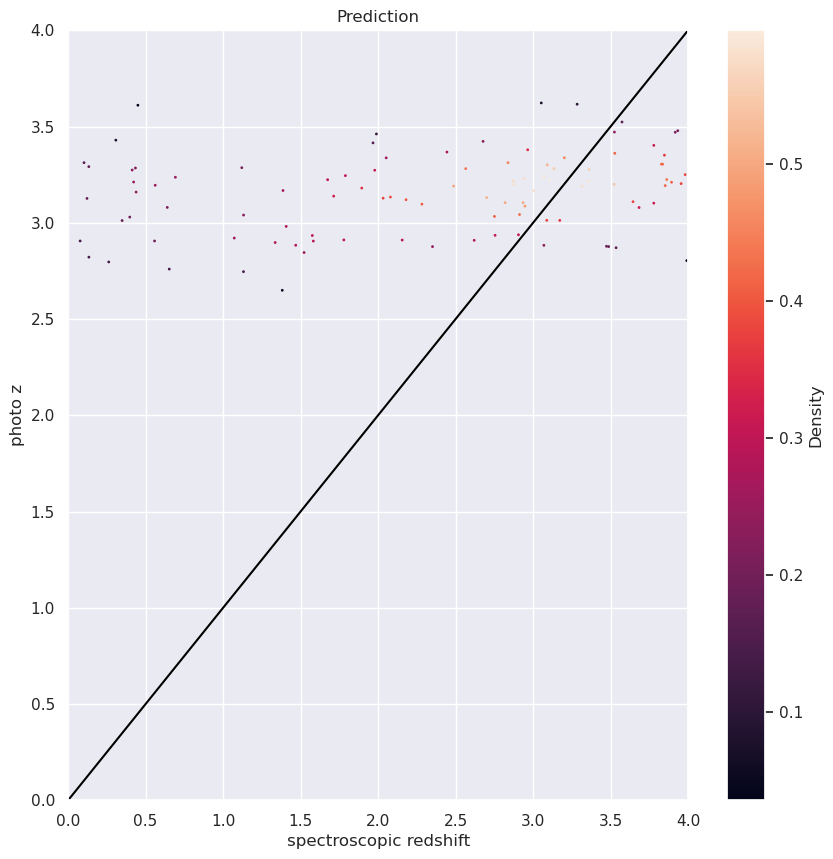

In [17]:
import seaborn as sns
z_max = 4
sns.set(rc={'figure.figsize': (10, 10), 'lines.markersize': 20})
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(specz, photoz, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

In [18]:
plt.imshow(x_test[100][:,:,4])

IndexError: index 100 is out of bounds for axis 0 with size 100

sns.set(rc={'figure.figsize':(10, 10), 'lines.markersize':20})
plt.rcParams.update({'font.size': 100})
sns.set(font_scale=3)

data = {'BCNN':10.7, 'BNN':19.7, 'Mizuki':27.4,
        'DEmP':25}
models_list = list(data.keys())
outlier_rates = list(data.values())

plt.bar(models_list, outlier_rates, color=('blue', 'red', 'red', 'red'))
plt.plot([-.5, 3.5], [15, 15], color = 'black', linestyle = 'dashed')
plt.title("Outlier Rates")
plt.ylabel("% Outlier Rate")
plt.xlabel("Model Type")
plt.show()

In [ ]:
overlap_variational = 0
overlap_array_variational = []
for i in range(0,t):
    if np.abs(specz[i]-photoz[i])<=photoz_err[i]:
        overlap_variational += 1
        overlap_array_variational.append(1)
    else:
        overlap_array_variational.append(0)

In [ ]:
sns.set(rc={'figure.figsize':(5, 5), 'lines.markersize':40})
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots()
display_size = 1000
scatter_plot = ax.scatter(specz[:display_size], photoz[:display_size], c = z[:display_size], s = 4, edgecolor = None, zorder = 2)
error_plot = ax.errorbar(specz[:display_size], photoz[:display_size], yerr = photoz_err[:display_size], fmt = "o", markersize = 0, color = 'blue', elinewidth = 1, zorder = 1)
plt.title('Prediction With Error')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.plot([0, z_max], [0, z_max], color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
print("Coverage: "+str(overlap_variational/t))

In [ ]:
combined_array_variational = np.transpose(np.vstack((specz, photoz, photoz_err, overlap_array_variational))) 

In [ ]:
sorted_combined_array_variational = sorted(combined_array_variational, key=lambda x: x[0])

In [ ]:
bins_variational = int(z_max*5)
splitted_sorted_combined_array_variational = np.array_split(sorted_combined_array_variational, bins_variational)
coverage_variational = []
for i in range(0, bins_variational):
    bins_count_variational = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        if splitted_sorted_combined_array_variational[i][j][3] == 1:
            bins_count_variational += 1
    coverage_variational.append(bins_count_variational/len(splitted_sorted_combined_array_variational[i])/0.6827)
x_array = np.arange(0, z_max, z_max/bins_variational)

In [ ]:
plt.plot(x_array, coverage_variational, c = 'red')
plt.title('Coverage')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Coverage')
plt.ylim([0, 1.5])
plt.plot([0, 4], [1, 1], color = 'black', linestyle = 'dashed')
plt.annotate("Underconfident", xy = (0, 1.06), color = 'black', size = 12)
plt.annotate("Overconfident", xy = (0, 0.9), color = 'black', size = 12)
print("Coverage: "+str(overlap_variational/t))

In [ ]:
mean_array = []
for i in range(0, bins_variational):
    total = 0
    for j in range(0, len(splitted_sorted_combined_array_variational[i])):
        bias = (splitted_sorted_combined_array_variational[i][j][1]-splitted_sorted_combined_array_variational[i][j][0])/(1 + splitted_sorted_combined_array_variational[i][j][0])
        total += bias/(1 + splitted_sorted_combined_array_variational[i][j][0])
    mean_array.append(total/len(splitted_sorted_combined_array_variational[i]))
x_array = np.arange(0, z_max, z_max/bins_variational)

In [ ]:
error_array = []
for i in range(0, bins_variational):
    error_total = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        error_total += splitted_sorted_combined_array_variational[i][j][2]
    error_array.append(error_total/len(splitted_sorted_combined_array_variational[i]))

In [ ]:
sns.set(rc={'figure.figsize':(5, 5), 'lines.markersize':40})
plt.rcParams.update({'font.size': 40})
plt.scatter(x_array, mean_array, marker='o', color = 'blue', s = 4)
# plt.errorbar(x_array, mean_array, yerr = error_array, fmt = "o", color = 'blue', markersize = 4, elinewidth = 2)
plt.title('Bias Plot for Probabilistic Model')
plt.xlabel('True Redshift')
plt.ylabel('Bias: (Predicted - True)/(1 + True)')
plt.plot([0, z_max], [0, 0], color = 'black')
plt.plot([0, z_max], [0.003, 0.003], color = 'black', linestyle = 'dashed')
plt.plot([0, z_max], [-0.003, -0.003], color = 'black', linestyle = 'dashed')
plt.ylim([-0.1, 0.1])
plt.show()

In [ ]:
combined_outlier_array = np.transpose(np.vstack((specz, photoz, photoz_err)))
sorted_combined_outlier_array = sorted(combined_outlier_array, key=lambda x: x[0])
bins_outlier = int(z_max*20)
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array,bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0,bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1] - splitted_sorted_combined_outlier_array[i][j][0]) >= 3 * splitted_sorted_combined_outlier_array[i][j][2]:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count/len(specz)*bins_outlier)
x_array_outlier = np.arange(0,z_max,z_max/bins_outlier)
plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.title('Outlier Rate')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0,z_max])
plt.ylim([0,1/2])
plt.show()

In [ ]:
combined_outlier_array = np.transpose(np.vstack((specz,np.subtract(photoz, specz))))
sorted_combined_outlier_array = sorted(combined_outlier_array, key=lambda x: x[0])
bins_outlier = int(z_max*10)
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array,bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0,bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1]/(splitted_sorted_combined_outlier_array[i][j][0] + 1)) >= .15:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count/len(specz)*bins_outlier)
x_array_outlier = np.arange(0,z_max,z_max/bins_outlier)
plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.title('Outlier Rate')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0,z_max])
plt.ylim([0,1])
plt.show()

# print("Outlier Rate: "+str(outlier_count_total/len(specz)))

In [ ]:
uncertains = []
for i in range(0, len(photoz_err)):
    if photoz_err[i].numpy() >= 1:
        uncertains.append(i)
        print("Spectro_z: " + str(specz[i]) + ", Photo_z: " + str(photoz[i]) + ", Photo_z_err: " + str(photoz_err[i].numpy()))

In [ ]:
check = 2
current = uncertains[check]
print("Spectro_z: " + str(specz[current]) + ", Photo_z: " + str(photoz[current]) + ", Photo_z_err: " + str(photoz_err[current].numpy()))
plt.imshow(x_test[current][:,:,0])
plt.grid(False)

In [ ]:
biases = []
for i in range(0, len(photoz)):
    if np.abs(photoz[i]-specz[i]) >= 1 and photoz_err[i].numpy() <= 0.5:
        biases.append(i)
        print("Spectro_z: " + str(specz[i]) + ", Photo_z: " + str(photoz[i]) + ", Photo_z_err: " + str(photoz_err[i].numpy()))

In [ ]:
check_bias = 3
current_bias = biases[check_bias]
print("Spectro_z: " + str(specz[current_bias]) + ", Photo_z: " + str(photoz[current_bias]) + ", Photo_z_err: " + str(photoz_err[current_bias].numpy()))
plt.imshow(x_test[current_bias][:,:,0])
plt.grid(False)

In [ ]:
a = 988
b = 264
c = 1198
d = 112
e = 241
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 5))
axes[0].imshow(x_test[a][:,:,0], cmap = 'afmhot')
axes[1].imshow(x_test[b][:,:,0], cmap = 'afmhot')
axes[2].imshow(x_test[c][:,:,0], cmap = 'afmhot')
axes[3].imshow(x_test[d][:,:,0], cmap = 'afmhot')
axes[4].imshow(x_test[e][:,:,0], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')
axes[4].axis('off')
# plt.title("Generated g Band Images")
# axes[0].set_title("Generated g Band Image 1", size = 5)
# axes[1].set_title("Generated g Band Image 2", size = 5)
# axes[2].set_title("Generated g Band Image 3", size = 5)
# axes[3].set_title("Generated g Band Image 4", size = 5)
# axes[4].set_title("Generated g Band Image 5", size = 5)
axes[0].annotate(f"z = {np.round(y_test[a][0], 3)}", xy = (10, 10), color = 'white', size = 10)
axes[1].annotate(f"z = {np.round(y_test[b][0], 3)}", xy = (10, 10), color = 'white', size = 10)
axes[2].annotate(f"z = {np.round(y_test[c][0], 3)}", xy = (10, 10), color = 'white', size = 10)
axes[3].annotate(f"z = {np.round(y_test[d][0], 3)}", xy = (10, 10), color = 'white', size = 10)
axes[4].annotate(f"z = {np.round(y_test[e][0], 3)}", xy = (10, 10), color = 'white', size = 10)
plt.show()

In [ ]:
a = 24
b = 15
c = 10
d = 96
e = 1868
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 5))
axes[0].imshow(x_train[a][:,:,0], cmap = 'afmhot')
axes[1].imshow(x_train[b][:,:,0], cmap = 'afmhot')
axes[2].imshow(x_train[c][:,:,0], cmap = 'afmhot')
axes[3].imshow(x_train[d][:,:,0], cmap = 'afmhot')
axes[4].imshow(x_train[e][:,:,0], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')
axes[4].axis('off')
# plt.title("Generated g Band Images")
# axes[0].set_title("Generated g Band Image 1", size = 5)
# axes[1].set_title("Generated g Band Image 2", size = 5)
# axes[2].set_title("Generated g Band Image 3", size = 5)
# axes[3].set_title("Generated g Band Image 4", size = 5)
# axes[4].set_title("Generated g Band Image 5", size = 5)
axes[0].annotate(f"z = {np.round(y_train[a][0], 3)}", xy = (10, 10), color = 'white', size = 10)
axes[1].annotate(f"z = {np.round(y_train[b][0], 3)}", xy = (10, 10), color = 'white', size = 10)
axes[2].annotate(f"z = {np.round(y_train[c][0], 3)}", xy = (10, 10), color = 'white', size = 10)
axes[3].annotate(f"z = {np.round(y_train[d][0], 3)}", xy = (10, 10), color = 'white', size = 10)
axes[4].annotate(f"z = {np.round(y_train[e][0], 3)}", xy = (10, 10), color = 'white', size = 10)
plt.show()

In [ ]:
for i in range(10000):
    if np.abs(y_train[i][0]-4)<0.1:
        print(i)

In [ ]:
# END